### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import glob
import datetime

import pickle
import json
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Helvetica']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 16

### Define Important Dates

In [2]:
launch_date = datetime.date(2023,2,28)

public_date = datetime.date(2024,2,6)

brazil_twitter_ban = datetime.date(2024,8,30)

ban_lift = datetime.date(2024,10,8)

block_policy = datetime.date(2024,10,16)

elections = datetime.date(2024,11,2)

reliable_date = datetime.date(2023,8,19)

focus_date = datetime.date(2024,8,21)

# **Read Data**

### **Network Stats**

In [3]:
# get the date info out
fp_with_date = [(f, datetime.datetime.strptime(f.split('_')[-1].split('.')[0], "%Y-%m-%d")) for f in glob.glob('/N/project/INCAS/bluesky/network/summary_stats/*')]

# sort by date
fp_with_date = sorted(fp_with_date, key=lambda x:x[1])

# iterate over the fps and get the summary statistics
summary_stats = []
for fp, date in fp_with_date:
    with open(fp, 'rb') as f:
        _ = pickle.load(f)
        summary_stats.append(_)

summary_stats = pd.DataFrame(summary_stats)

summary_stats['day'] = summary_stats['day'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d'))
summary_stats['after_launch'] = summary_stats['day'].apply(lambda x: x.date())>launch_date

summary_stats = summary_stats.drop(columns = ['cc_sizes_list_undir', 'cc_sizes_list_dir'])

summary_stats = summary_stats.sort_index()

summary_stats.index = summary_stats['day']

summary_stats.columns = ['date', 'node_count', 'edge_count', 'avg_degree', 'largest_cc_size_undir', 
                        'largest_cc_size_dir', 'clustering_coef', 'clustering_coef_std', 'after_launch']
summary_stats.index = summary_stats['date']

# replace index
summary_stats.index = [i.date() for i in summary_stats.index]

# drop clustering coef
summary_stats = summary_stats.drop(columns=['clustering_coef', 'clustering_coef_std'])

In [ ]:
summary_stats = summary_stats[summary_stats.index>=reliable_date]

### **Clustering coefficient**

In [ ]:
# create the file path list and sort
cc_fp_list = glob.glob('/N/project/exodusbsky/processed/network/FollowerNetworkPropertiesNew/*.pkl')
cc_fp_list = sorted([(fp, datetime.datetime.strptime(fp.split('_')[-1].split('.')[0], '%Y-%m-%d').date()) for fp in cc_fp_list], key=lambda x: x[1])

avg_degree = {}
clustering_coef = {}
for fp, date in tqdm(cc_fp_list):
    temp = pd.read_pickle(fp)
    cc = temp['clustering_coefficients']
    clustering_coef[date] = np.nanmean(cc)

clustering_coef = pd.DataFrame(clustering_coef.items())

# set index as the date
clustering_coef.index = clustering_coef[0]

# get node counts
clustering_coef = clustering_coef.merge(summary_stats['node_count'], right_index=True, left_index=True)

# drop the date
clustering_coef = clustering_coef.drop(columns=[0])

# rename the columns
clustering_coef.columns = ['Clustering Coefficient', 'node_count']

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [04:49<00:00,  1.35it/s]


In [6]:
clustering_coef = clustering_coef[clustering_coef.index>=reliable_date]

### **Engagement**

In [7]:
engagement_by_user_group = pd.read_parquet('/N/project/exodusbsky/processed/account_activity_count_by_day/total_engagement_by_day_by_user.parquet')

In [8]:
engagement_by_user_group.columns = ['All', 'Brazil X Ban', 'US Elections', 'Public Access', 'X Block Policy Change']

In [9]:
user_group_date_intervals = {'Public Access': {'start': datetime.date(2024, 2, 4),
                                                'end': datetime.date(2024, 2, 19)},
                            'Brazil X Ban': {'start': datetime.date(2024, 8, 28),
                                                'end': datetime.date(2024, 10, 3)},
                            'X Block Policy Change': {'start': datetime.date(2024, 10, 14),
                                                     'end': datetime.date(2024, 11, 1)},
                            'US Elections': {'start': datetime.date(2024, 11, 2),
                                            'end': datetime.date(2024, 11, 29)},
                            'All': {'start': datetime.date(2023, 8, 19)}}

#### Engagement by Others

In [10]:
engagement_by_user_group['Other'] = engagement_by_user_group['All'] - engagement_by_user_group[[*engagement_by_user_group.columns][1:]].sum(axis=1)

In [11]:
engagement_by_user_group = engagement_by_user_group.merge(summary_stats['node_count'], right_index=True, left_index=True)

### **Profile Creations**

In [48]:
profile_creations = pd.read_parquet('/N/project/INCAS/bluesky/profile_creations/profile_creations.parquet')

In [49]:
profile_creations['Cumulative User Count'] = profile_creations['All'].cumsum()

In [50]:
profile_creations = profile_creations[profile_creations.index>=reliable_date]

In [72]:
with open('/N/project/INCAS/bluesky/profile_creations/user_group_date_intervals.pickle', 'rb') as f:
    intervals = pickle.load(f)

mapping = {'public_date_group_interval':'Public Access',
        'brazil_ban_interval':'Brazil X Ban',
        'block_policy_change_interval':'X Block Policy Change',
        'election_interval':'US Elections'}

intervals = {mapping[k]:v for k,v in intervals.items()}

#### Add User Count Info to Summary Stats

In [52]:
summary_stats = summary_stats.merge(profile_creations['Cumulative User Count'], right_index=True, left_index=True)

### **Average Engagement**

In [ ]:
avg_engagement = engagement_by_user_group.merge(profile_creations['Cumulative User Count'], right_index=True, left_index=True)
avg_engagement = avg_engagement['All']/avg_engagement['Cumulative User Count']
avg_engagement = pd.DataFrame(avg_engagement, columns=['Avg Engagement'])

### **Activity per Active User**

In [58]:
per_user_activity = pd.read_parquet('/N/project/exodusbsky/processed/account_activity_count_by_day/active_user_count_per_day_0_8.parquet')

per_user_activity['focus'] = False


per_user_activity = per_user_activity.reset_index()

per_user_activity.columns = ['Date',
                            'Brazil X Ban Count',
                            'Other Count',
                            'Public Access Count',
                            'US Elections Count',
                            'X Block Policy Change Count',
                            'Brazil X Ban Total Engagement',
                            'Other Total Engagement',
                            'Public Access Total Engagement',
                            'US Elections Total Engagement',
                            'X Block Policy Change Total Engagement',
                            'User Count',
                            'Total Engagement',
                            'Focus']

# reindex and drop date column
per_user_activity.index = per_user_activity['Date']
per_user_activity = per_user_activity.drop(columns=['Date'])

per_user_activity = per_user_activity.merge(summary_stats[['node_count']],right_index=True, left_index=True, how='left')

# interpolate missing values
per_user_activity['node_count_filled'] = per_user_activity['node_count'].interpolate(method='linear', limit_direction='both')

# find the ratio of active users
per_user_activity['Ratio of Active Users'] = per_user_activity['User Count']/per_user_activity['node_count_filled']

In [60]:
per_user_activity = per_user_activity[per_user_activity.index>=reliable_date]

### **Avg Degree by User Group**

In [64]:
fp_list = glob.glob('/N/project/INCAS/bluesky/network/group_degree_distributions/*')

fp_list = [(f, datetime.datetime.strptime(f.split('_')[-1].split('.')[0], '%Y-%m-%d').date()) for f in fp_list]

fp_list = sorted(fp_list, key=lambda x:x[1])

In [65]:
group_based_degree = []
for fp, date in tqdm(fp_list):
    temp = pd.read_pickle(fp)
    # keep only the averages
    temp = {k:{k_:v_ for k_, v_ in v.items() if k_ in {'avg_indegree', 'avg_outdegree'}} for k,v in temp.items()}
    group_based_degree.append(temp)

group_based_degree = pd.DataFrame(group_based_degree, index=[f[1] for f in fp_list])

group_based_degree = group_based_degree[group_based_degree.index>=reliable_date]

group_based_degree.columns = ['Public Access', 'Brazil X Ban', 'X Block Policy Change', 'US Elections']

# get node counts
group_based_degree = group_based_degree.merge(summary_stats['node_count'],right_index=True,left_index=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [01:51<00:00,  3.50it/s]


### **Degree Inequality**

In [66]:
fp_list = glob.glob('/N/project/INCAS/bluesky/network/gini_and_kappa/*')

fp_list = [(f, datetime.datetime.strptime(f.split('/')[-1].split('.')[0], '%Y-%m-%d').date()) for f in fp_list]

fp_list = sorted(fp_list, key=lambda x: x[1])

In [67]:
ineq_measures = []

for fp, date in fp_list:
    with open(fp, 'r') as f:
        d = json.load(f)
    d['date'] = date
    
    ineq_measures.append(d)

ineq_measures = pd.DataFrame(ineq_measures)

ineq_measures.index = ineq_measures['date']

ineq_measures = ineq_measures[ineq_measures.index>=reliable_date]

# merge node counts
ineq_measures = ineq_measures.merge(summary_stats['node_count'],left_index=True,right_index=True)

# **Visualize**

In [69]:
colors = {
        'All':'black',
        'Other':'#6A3D9A',
        'Brazil X Ban':'#006ba4',
        'US Elections':'#ff800e',
        'Public Access':'#8B0000',
        'X Block Policy Change':'#FFC0CB',
        'en':'#ff800e',
        'pt':'#006ba4',
        'ja':'#8B0000',
        }

In [70]:
important_dates = {'Public Access':public_date, 'Brazil X Ban':brazil_twitter_ban, 'X Block Policy Change':block_policy, 'US Elections':elections}
important_node_counts = {k:summary_stats[summary_stats.index==v]['node_count'].iloc[0] for k,v in important_dates.items()}

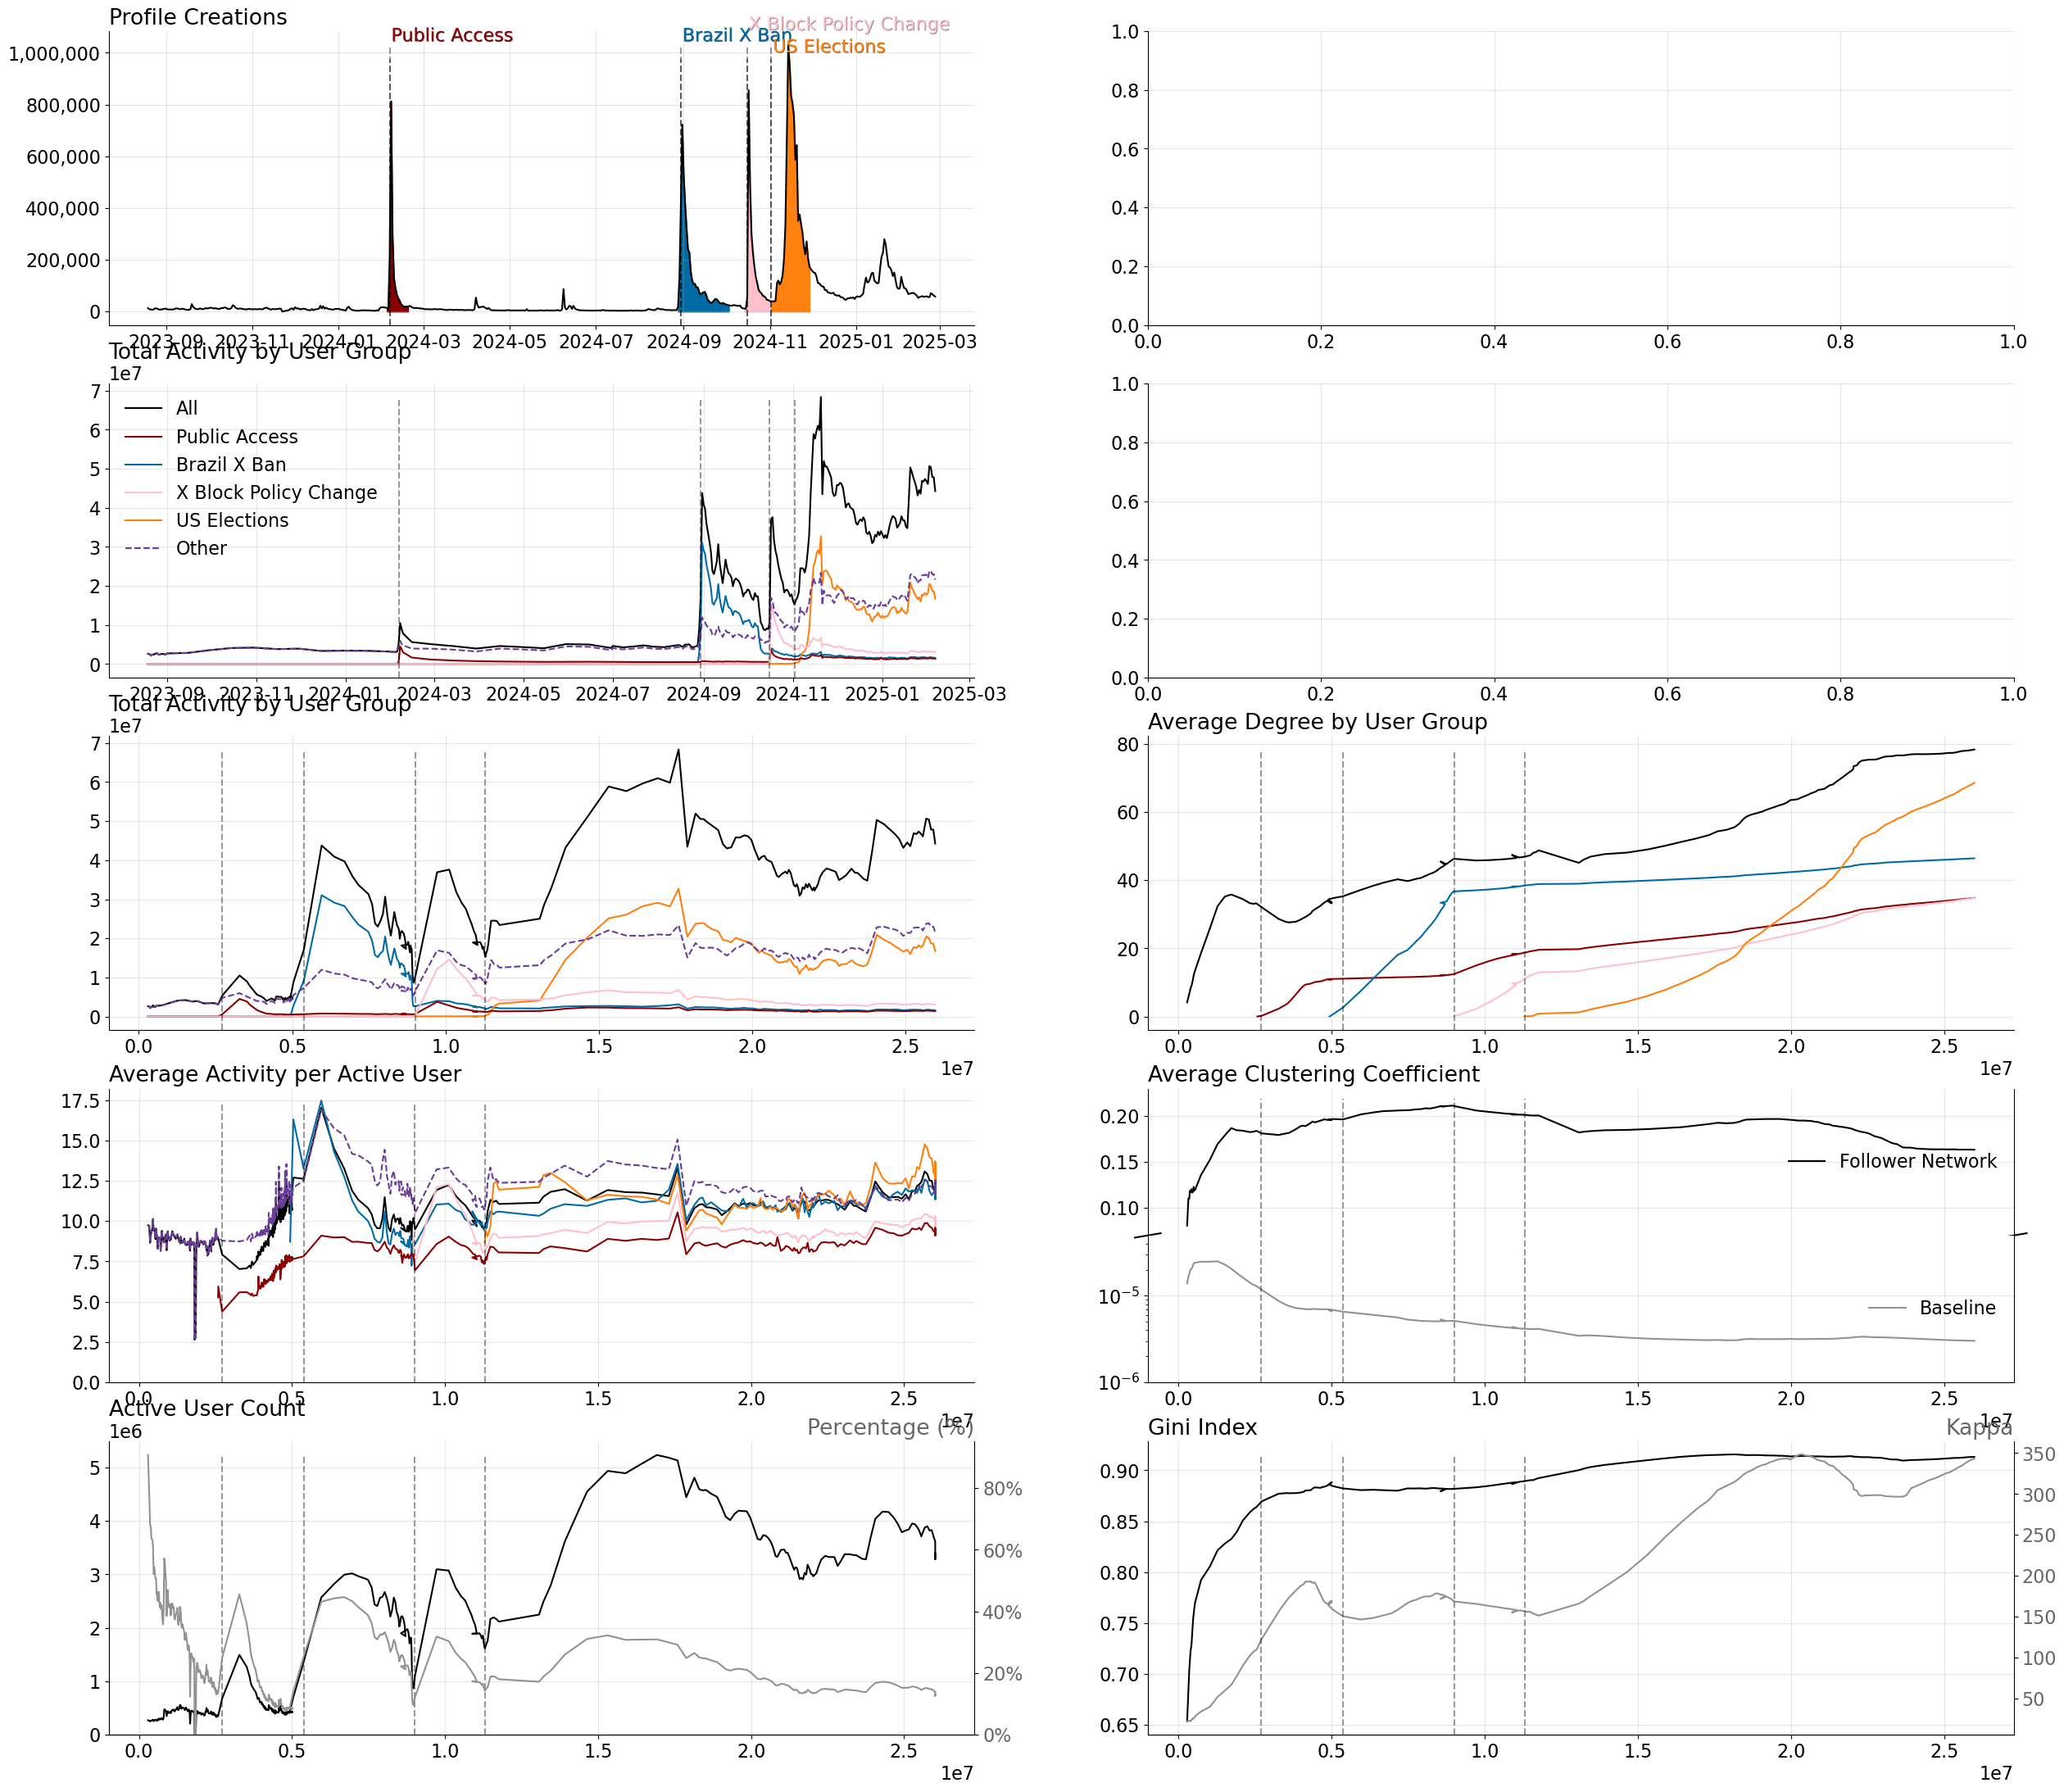

In [153]:
fig, axs = plt.subplots(5,2,figsize=(30,27))


axs[0][0].plot(profile_creations['All'], color = 'black', label='All')

for label, v in intervals.items():
    start_date, end_date = v['start'], v['end']
    FILTER = (profile_creations.index >= start_date) & (profile_creations.index <= end_date)
    axs[0][0].fill_between(profile_creations[FILTER].index,
                            profile_creations[FILTER]['All'],
                            color=colors[label],
                            label=label
                            )

# ------------------------------------------------------------------
# FIGURE [1][0]
for group_name in ['All', 'Brazil X Ban', 'US Elections', 'Public Access', 'X Block Policy Change']:
    d = engagement_by_user_group#[(engagement_by_user_group.index>=focus_date)]
    axs[1][0].plot(d[group_name], label = group_name, color = colors[group_name])

ymin, ymax = axs[1][0].get_ylim()

axs[1][0].plot(engagement_by_user_group['Other'], label ='Other', color = '#6A3D9A', linestyle = 'dashed')

legend_handles, legend_labels = axs[1][0].get_legend_handles_labels()
# sort both labels and handles based on the ordering
label_ordering = {'All':0, 'Brazil X Ban':2, 'US Elections':4, 'Public Access':1, 'X Block Policy Change':3, 'Other':5}
_, legend_handles, legend_labels = zip(*sorted([(label_ordering[l],h,l) for h,l in zip(legend_handles, legend_labels)]))

# labels, handles = zip(*sorted(zip(legend_labels, legend_handles), key=lambda t: t[0]))
axs[1][0].legend(legend_handles, legend_labels, frameon=False, loc='upper left')

# ------------------------------------------------------------------

# ------------------------------------------------------------------
# FIGURE [2][0]
for group_name in ['All', 'Brazil X Ban', 'US Elections', 'Public Access', 'X Block Policy Change']:
    axs[2][0].plot(engagement_by_user_group['node_count'], engagement_by_user_group[group_name], label = group_name, color = colors[group_name])

axs[2][0].plot(engagement_by_user_group['node_count'], engagement_by_user_group['Other'], label ='Other', color = '#6A3D9A', linestyle = 'dashed')
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# FIGURE [3][0]
axs[3][0].plot(per_user_activity['node_count_filled'],
               per_user_activity['Total Engagement']/per_user_activity['User Count'],
               color='black')

for group_name in ['Brazil X Ban', 'X Block Policy Change', 'US Elections', 'Public Access', 'Other']:
    if group_name != 'Other':
        d = per_user_activity[(per_user_activity.index >= user_group_date_intervals[group_name]['start'])]
    else:
        d = per_user_activity
    
    axs[3][0].plot(d['node_count_filled'], 
                d[f'{group_name} Total Engagement']/d[f'{group_name} Count'],
                label = group_name,
                color=colors[group_name],
                linestyle='dashed' if group_name == 'Other' else 'solid')
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# FIGURE [4][0]
axs[4][0].plot(per_user_activity['node_count_filled'],
               per_user_activity['User Count'], color='black')


axs_4_0 = axs[4][0].twinx()
axs_4_0.plot(per_user_activity['node_count_filled'],
             per_user_activity['Ratio of Active Users'], color='#929292')
axs_4_0.set_title('Percentage (%)', loc='right', color='#676767')
axs_4_0.spines['top'].set_visible(False)
vals = axs_4_0.get_yticks()
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# FIGURE [2][1]

axs[2][1].plot(summary_stats['node_count'], summary_stats['avg_degree'], label='All', color='black')
for group_name in ['Public Access', 'Brazil X Ban', 'X Block Policy Change', 'US Elections']:
    d = group_based_degree[(group_based_degree.index >= user_group_date_intervals[group_name]['start'])]
    axs[2][1].plot(d['node_count'], d[group_name].apply(lambda x: x['avg_indegree']), label = group_name, color=colors[group_name])
# ------------------------------------------------------------------

# ------------------------------------------------------------------
# FIGURE [3][1]

# Get position of CC subplot axs[2][1] within the grid
target_ax = axs[3][1]
pos = target_ax.get_position()  # Bbox with [x0, y0, width, height]
target_ax.remove()  # Remove the original axis

# Calculate positions for the two new axes within the original subplot's area.
# Here we split the area vertically into two equal parts.
x0, y0, width, height = pos.x0, pos.y0, pos.width, pos.height
height_half = height / 2

# Create the top axis (for clustering coefficient)
ax_top = fig.add_axes([x0, y0 + height_half, width, height_half])
# Create the bottom axis (for normalized average degree)
ax_bottom = fig.add_axes([x0, y0, width, height_half], sharex=ax_top)

# --- Top Axis: CC ---
ax_top.plot(clustering_coef['node_count'], 
            clustering_coef["Clustering Coefficient"], 
            color="black", 
            label="Follower Network")
ax_top.set_ylim(0.07, 0.23)
# Hide the bottom spine
ax_top.spines["bottom"].set_visible(False)
ax_top.tick_params(labelbottom=False)

# --- Bottom Axis: Random net p ---
normalized_avg_degree = summary_stats["avg_degree"] / summary_stats["node_count"]
ax_bottom.plot(clustering_coef['node_count'], 
                normalized_avg_degree, color="#929292", label="Baseline"
                )

ax_bottom.set_ylim(0.000001, 0.00005)
ax_bottom.set_yscale("log")

# Add diagonal break lines to indicate the axis break
d = 0.015  # size of the diagonal lines in axes coordinates
kwargs_top = dict(transform=ax_top.transAxes, color="k", clip_on=False)
ax_top.plot((-d, +d), (-d, +d), **kwargs_top)
ax_top.plot((1 - d, 1 + d), (-d, +d), **kwargs_top)

ax_top.spines["top"].set_visible(False)
ax_bottom.spines["top"].set_visible(False)

ax_top.grid(alpha=.3)
ax_bottom.grid(alpha=.3)
ax_top.set_title('Average Clustering Coefficient', loc='left')


ax_top.legend(frameon=False, loc='right')
ax_bottom.legend(frameon=False, loc='right')


# ------------------------------------------------------------------

# ------------------------------------------------------------------
# FIGURE [4][1]
axs[4][1].plot(ineq_measures['node_count'], ineq_measures['gini'], color='black')
axs_4_1 = axs[4][1].twinx()
axs_4_1.plot(ineq_measures['node_count'], ineq_measures['kappa'], color='#929292')

axs[4][1].set_title('Gini Index', loc='left')
axs_4_1.set_title('Kappa', loc='right', color='#676767')
axs_4_1.spines['top'].set_visible(False)
# ------------------------------------------------------------------

# ------------------------------------------------------------------
### Global Adjustments
titles = ['Profile Creations', '', 'Total Activity by User Group', '', 'Total Activity by User Group',
          'Average Degree by User Group', 'Average Activity per Active User', 'Average Clustering Coefficient', 'Active User Count', 'Gini Index']
i = 0
for row in range(5):
    for col in range(2):
        for dir in ['top', 'right']:
            if (row,col)!=(3,1):
                axs[row][col].spines[dir].set_visible(False)
                axs[row][col].grid(alpha=.3)
                axs[row][col].set_title(titles[i], loc='left')
        i+=1
# ------------------------------------------------------------------

# ------------------------------------------------------------------
### Show 0s
for ax in [
    axs[3][0], 
    axs[4][0], 
    axs_4_0
    ]:
    ymin, ymax = ax.get_ylim()
    ax.set_ylim(0, ymax)
# ------------------------------------------------------------------

# ------------------------------------------------------------------
### Formatting ytick values
def comma_formatter(x, pos):
    return f'{int(x):,}'
def millions_formatter(x, pos):
    """The two args are the value and tick position."""
    return f'{x*1e-6:.0f}M'
axs[0][0].yaxis.set_major_formatter(ticker.FuncFormatter(comma_formatter))
#axs[4][1].yaxis.set_major_formatter(ticker.FuncFormatter(millions_formatter))
axs_4_0.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
# ------------------------------------------------------------------

# ------------------------------------------------------------------
### Log Scale
# for ax in [axs[2][0]]:
#     ax.set_yscale('log')
# ------------------------------------------------------------------

# ------------------------------------------------------------------
### Recolor y tick values for twinx() instances
for ax in [
            axs_4_0, 
            axs_4_1
           ]:
    ax.tick_params(axis='y', labelcolor='#676767')
# ------------------------------------------------------------------

# ------------------------------------------------------------------
### Overall Adjustments 
# Remove unused ax
#axs[0][1].remove()
#axs[0][2].remove()
# ------------------------------------------------------------------

# ------------------------------------------------------------------
### Add vlines
for ax in [axs[0][0], axs[1][0]]:
    ymin, ymax = ax.get_ylim()
    for event, date in [*important_dates.items()]:
        ax.vlines(date, ymin, ymax*.95, color='black', linestyles='--', alpha=.4)
    ax.set_ylim(ymin,ymax)

for ax in [axs[2][0], axs[3][0], axs[4][0], axs[2][1], axs_4_1]:
    ymin, ymax = ax.get_ylim()
    for event, date in [*important_node_counts.items()]:
        ax.vlines(date, ymin, ymax*.95, color='black', linestyles='--', alpha=.4)
    ax.set_ylim(ymin,ymax)

for coef, ax in zip([1, .95], [ax_bottom, ax_top]):
    ymin, ymax = ax.get_ylim()
    for event, date in [*important_node_counts.items()]:
        ax.vlines(date, ymin, ymax*coef, color='black', linestyles='--', alpha=.4)
    ax.set_ylim(ymin,ymax)
# ------------------------------------------------------------------

# ------------------------------------------------------------------
### Add text
i = 0
ymin, ymax = axs[0][0].get_ylim()
for event, date in important_dates.items():
    axs[0][0].vlines(date, ymin, ymax*.9, color='black', linestyles='--', alpha=.4)
    text = axs[0][0].text(date+datetime.timedelta(1),
                        ymax*[0.95,0.95,0.99,0.91][i],
                        event, 
                        verticalalignment='bottom',
                        horizontalalignment='left',
                        color=colors[event]
                        )
    
    text.set_path_effects([path_effects.withSimplePatchShadow(offset=(0.5, -0.5), alpha=0.7)])

    i += 1
axs[0][0].set_ylim(ymin,ymax)


fig.savefig('/N/u/oseckin/BigRed200/bluesky_brazilian_migration/figures/main_fig.pdf')